## Introduction

This project is meant for learning and practicing different Deep learninig techniques (including transfer learning & data augmentation) to develop an emotion and gender detection using Convolutional Neural Networks. The aim is to develop different models to predict taking webcam pictures as an input. The main metric for model evaluation is validation & test accuracy as this can be measured easily however the actual prediction from webcam can be considered the true performance metric. 

The project features:
- Two models for emotion detection, one with traditional learning and one with transfer learning using Resnet50. 
- One model for gender detection using Mobilnet_v2 as pre-trained model. 

Some important points behind thought process.
- During model architectures we opt for deeper models (more layers) rather than wider as this was proven more effective.
- GlobalAveragePooling2D reduces learning parameter and can be more effective than Flatten.
- Even though different optimizers were experimented briefly we ended up only using Adam as this has become more common used and works overall well.
- In later model experimentation the aim was to reduce overftting, this was done by introducing data augmentation very carefully as it would otherwise introduce too much noise in our relatively small datasets. 
- Dropout and L2 regulariziers was used in conjunctively to reduce overfit and proved to work positively. 
- When using pre-trained model the model-specific preprocessing function was used to ensure proper intended input into the training models. 

As we became too enthusiastic with model experimentation some code lines were accidently reran resulting in overwritten cells. This means that all cell outputs is not correct. We simply could not retrain and replicate the models for the sake of the cell output. Fortunately the models had already been saved.

Final result:
'emo_model_wa_6158.keras' - emotion detection with augmentation (modelname_trainacc&valacc.keras)
'my_model_pt_6356.keras' - emotion detection with pretrained resnet50 without augmentation (modelname_trainacc&valacc.keras)
'my_model_pt_8783.keras' - gender detection with pretrained mobilenet_v2 with augmentatiton (modelname_trainacc&valacc.keras)

For prediction see images in github seperately.

//Keikiet Pham

När du är klar med koden skall du i slutet av skriptet besvara följande frågeställningar: 
1.	Utmaningar du haft under arbetet samt hur du hanterat dem. 
    Det har varit svårt att förstå modellerna och man har väldigt sällan en aning hur bra modellen kommer tränas på förhand. Detta gör att modelexperimentering har lång tid. En annan utmaning men som varit roligt är att veta hur man kan förbättra modellen. Det finns mycket information att grotta ner sig i på nätet om man vet vad man ska söka på.
2.	Vilket betyg du anser att du skall ha och varför. 
    Jag hoppas och anser att jag uppnår VG-kriterier, då försökt motivera mina val och deusstom har fördjupat mig i en av model building med pretrained models och data-augmentation men även gjort en gender detector.
3.	Tips du hade ”gett till dig själv” i början av kursen nu när du slutfört den. 
    Dokumentera ditt arbete under projektets gång! Underskattat!!


### Importing Libraries and Packages

In [478]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

from collections import Counter

import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras import layers
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, InputLayer
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


## Emotion Classifier

### a) Preparing the Dataset

In [479]:
# Define directories
base_dir = '/Users/keikietpham/Desktop/Kunskapskontroll2_DeepLearning/images/'
train_dir = os.path.join(base_dir, 'train') # training dataset
test_dir = os.path.join(base_dir, 'validation')

#### Exploring and Displaying Images

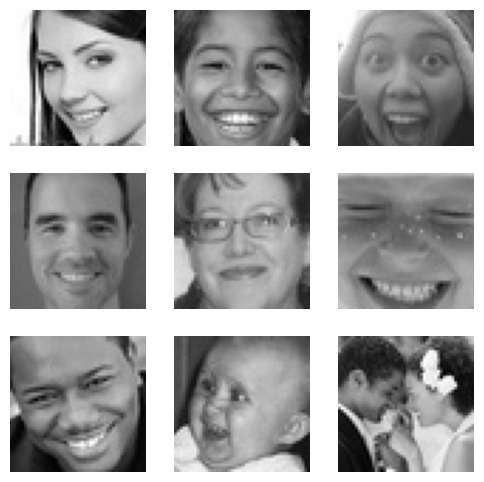

In [480]:
# Image parameters
picture_size = 48 # use lower picture resolution to reduce training and computation time. 

# Image category
expression = 'happy'

# Shuffle images that will be displayed
shuffle_list = os.listdir(base_dir + "train/" + expression) 
random.shuffle(shuffle_list)

plt.figure(figsize= (6,6))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(base_dir + "train/" + expression + "/" + shuffle_list[i], target_size=(picture_size, picture_size))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

#### Checking for data imbalance

In [483]:
# Function to count class distribution
def count_class_distribution(dataset):
    class_counter = Counter()
    for _, labels in dataset.unbatch():
        class_ids = tf.argmax(labels, axis=-1)
        class_counter.update(class_ids.numpy().tolist() if class_ids.ndim > 0 else [class_ids.numpy()])
    return class_counter

# Count and print class distribution in the training dataset
train_class_distribution = count_class_distribution(train_datagen)
print("Class distribution in the training set:")
for class_index, count in sorted(train_class_distribution.items()):
    print(f'Class {class_index}: {count} images')
    
# Print a line break
print()

 # Count and print class distribution in the validation dataset
val_class_distribution = count_class_distribution(val_datagen)
print("Class distribution in the validation set:")
for class_index, count in sorted(val_class_distribution.items()):
    print(f'Class {class_index}: {count} images')   



2024-05-30 21:21:38.805003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class distribution in the training set:
Class 0: 2002 images
Class 1: 217 images
Class 2: 2069 images
Class 3: 3608 images
Class 4: 2483 images
Class 5: 2446 images
Class 6: 1586 images

Class distribution in the validation set:
Class 0: 1991 images
Class 1: 219 images
Class 2: 2034 images
Class 3: 3556 images
Class 4: 2499 images
Class 5: 2492 images
Class 6: 1619 images


2024-05-30 21:21:40.601949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Creating Training, Validation and Test dataset

In [484]:
# Set batch size 
batch_size = 32

# Load Train & Validation datasets
train_datagen, val_datagen = image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale', # training dataset consists of gray images
    batch_size=batch_size,
    image_size=(picture_size, picture_size),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

# Load Test dataset
test_datagen = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale', # test dataset consists of gray images
    batch_size=batch_size,
    image_size=(picture_size, picture_size),
    shuffle=False
)


Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Using 5764 files for validation.
Found 7066 files belonging to 7 classes.


### b) Data-Augmentation & Preprocessing

In [486]:
img_resize = 48

# Define the data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.02),
    tf.keras.layers.RandomZoom(height_factor=0.02, width_factor=0.02),
    tf.keras.layers.RandomContrast(factor=0.02),
    tf.keras.layers.RandomBrightness(factor=0.02),
    tf.keras.layers.Resizing(img_resize, img_resize),
])

# Data augmentation will not be used as it did not improve model performance. Potential reason could be due 
# to dataset already consisting of a large variety of images that have the same effect as above (zoom, rotation, different brightness etc.). 
# Another reason is haarcascade and a roi (range of interest) function will be used to create a frame around face,
# which will identify a face, if the data augmentation such as rotation is significant, the functions may fail to
# identify.

def resize_augment(image, label):
    image = data_augmentation(image)
    return image, label

2024-05-30 21:21:51.868021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


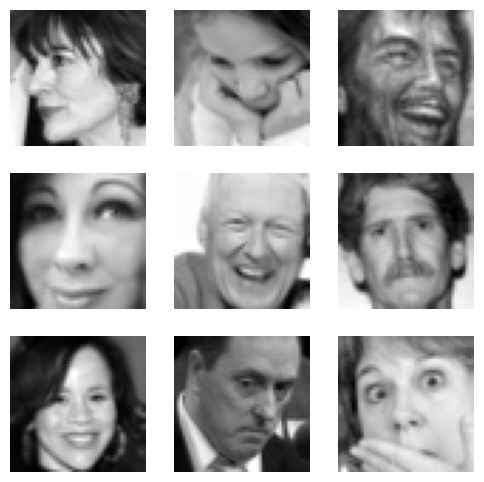

In [487]:
# Display random images after data_augmentation above

plt.figure(figsize=(6, 6))
for images, _ in train_datagen.take(1):  # Take one batch from the dataset
    for i in range(9):
        augmented_images = data_augmentation(images)
        
        ax = plt.subplot(3, 3, i + 1)
        
        # Convert to float32 to ensure greyscale and rescaling
        img = np.array(augmented_images[i]).astype("float32")
        
        plt.imshow(img, cmap='gray')  # Use 'gray' colormap for greyscale images
        plt.axis("off")

plt.show()

In [488]:
# Apply resizing and data augmentation
train_augmented = train_datagen.map(resize_augment)

#### Implement Class weights to counter data imbalance

In [489]:
# Get class names from the directory structure
class_names = sorted(os.listdir(train_dir))

# Print the class indices and names
print("Class indices and their corresponding names:")
for index, class_name in enumerate(class_names):
    print(f'Class {index}: {class_name}')

Class indices and their corresponding names:
Class 0: .DS_Store
Class 1: angry
Class 2: disgust
Class 3: fear
Class 4: happy
Class 5: neutral
Class 6: sad
Class 7: surprise


In [490]:
class_weights = {0: 2,  # angry
                 1: 20,  # disgust
                 2: 2,  # fear
                 3: 1,  # happy
                 4: 1.5,  # neutral
                 5: 1.5,  # sad
                 6: 2.5}  # surprise

# Remove '.DS_Store' from class names. (.DS_Store is a hidden folder created in MacOS)
class_names = [name for name in class_names if name != '.DS_Store']



### c) Model 1

#### Model Architecture

In [ ]:
# Define the CNN model
def build_emotion_model(input_shape):
    model = Sequential()
    model.add(keras.Input(shape=(input_shape)))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2))) # Remove layer to maintain spatial dimension
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2))) # Remove layer to maintain spatial dimension
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D()) # use GlobalAveragePooling instead of flatten to reduce overfit and number of parameter
    
    model.add(Dense(512, kernel_regularizer=l2(0.01))) # Apply l2 regularizer to discourages large weights and prevent overfitting.
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(512, kernel_regularizer=l2(0.01))) # Apply l2 regularizer to discourages large weights and prevent overfitting.
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(len(class_names), activation='softmax'))  # Set output layer size based on number of classes
    
    return model

input_shape = (picture_size, picture_size, 1)
model = build_emotion_model(input_shape)

In [501]:
# Print model summary
model.summary()

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_76 (Activation)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_77 (Activation)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_78 (Activation)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,466,823 (17.04 MB)

 Trainable params: 4,461,767 (17.02 MB)

 Non-trainable params: 5,056 (19.75 KB)

#### Compiling

In [502]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#### Training

In [503]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=0.0001)


In [504]:
# Train the model with class weights
history = model.fit(
    #train_datagen,
    train_augmented, # test model with resize, rescale & augment
    validation_data=val_datagen,
    epochs=100,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


721/721 ━━━━━━━━━━━━━━━━━━━━ 93s 125ms/step - accuracy: 0.1474 - loss: 12.0504 - val_accuracy: 0.1511 - val_loss: 4.0982 - learning_rate: 0.0010
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 92s 127ms/step - accuracy: 0.1666 - loss: 5.3293 - val_accuracy: 0.1216 - val_loss: 4.4796 - learning_rate: 0.0010
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 88s 122ms/step - accuracy: 0.2071 - loss: 4.2729 - val_accuracy: 0.1360 - val_loss: 2.7294 - learning_rate: 0.0010
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 91s 127ms/step - accuracy: 0.2567 - loss: 4.1739 - val_accuracy: 0.3246 - val_loss: 2.1928 - learning_rate: 0.0010
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 92s 127ms/step - accuracy: 0.2824 - loss: 3.9686 - val_accuracy: 0.3409 - val_loss: 2.1921 - learning_rate: 0.0010
Epoch 6/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 94s 130ms/step - accuracy: 0.2987 - loss: 3.8937 - val_accuracy: 0.3321 - val_loss: 2.2547 - learning_rate: 0.0010
Epoch 7/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 92s 127ms/step - accuracy: 0.3178 

#### Model Evaluation

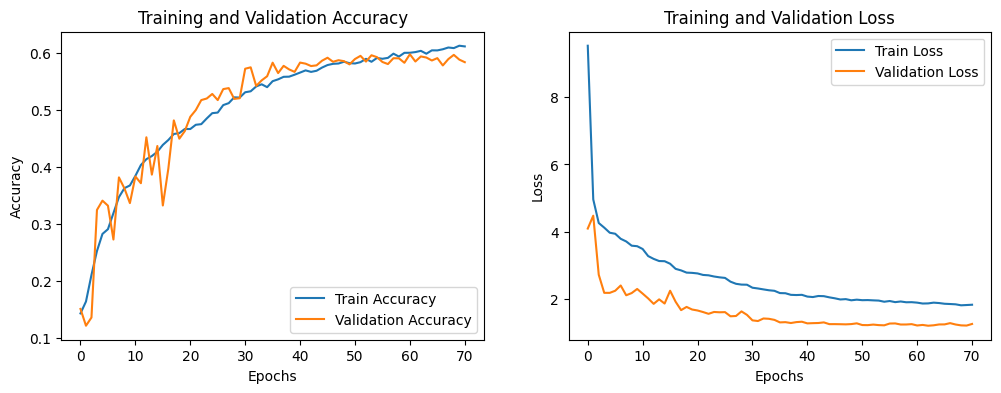

In [505]:
# Plot training history: Model 1 - Emotion Classifier
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [506]:
# Evaluate test accuarcy
test_loss, test_accuracy = model.evaluate(test_datagen)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

  4/221 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5729 - loss: 1.2483 

221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5560 - loss: 1.2726
Test Accuracy: 59.95%


#### Save Model

In [507]:
## Save the my model with data augmentation
model.save('emo_model_wa_6158.keras')

### Model 2 - Transfer Learning with Resnet50

In [630]:
# import ResNet50 pretrained model 
pt_resnet50_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)

pt_resnet50_model.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_110     │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_110[… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [634]:
# Freeze base model and make custom layers trainable
pt_resnet50_model.trainable = False  # Freezing the base model

# checking if the layers are trainable
for layer in pt_resnet50_model.layers:
    print(f'Layer name: {layer}, is trainable: {layer.trainable}')

Layer name: <InputLayer name=input_layer_110, built=True>, is trainable: False
Layer name: <ZeroPadding2D name=conv1_pad, built=True>, is trainable: False
Layer name: <Conv2D name=conv1_conv, built=True>, is trainable: False
Layer name: <BatchNormalization name=conv1_bn, built=True>, is trainable: False
Layer name: <Activation name=conv1_relu, built=True>, is trainable: False
Layer name: <ZeroPadding2D name=pool1_pad, built=True>, is trainable: False
Layer name: <MaxPooling2D name=pool1_pool, built=True>, is trainable: False
Layer name: <Conv2D name=conv2_block1_1_conv, built=True>, is trainable: False
Layer name: <BatchNormalization name=conv2_block1_1_bn, built=True>, is trainable: False
Layer name: <Activation name=conv2_block1_1_relu, built=True>, is trainable: False
Layer name: <Conv2D name=conv2_block1_2_conv, built=True>, is trainable: False
Layer name: <BatchNormalization name=conv2_block1_2_bn, built=True>, is trainable: False
Layer name: <Activation name=conv2_block1_2_relu, 

#### Creating Training, Validation and Test dataset

In [636]:
import os

image_size = 224

train_generator, val_generator = image_dataset_from_directory(
        directory=train_dir,
        image_size=(image_size, image_size),
        batch_size=256,
        label_mode='categorical',
        color_mode = 'rgb',
        shuffle = True,
        seed=42,
        validation_split=0.2,
        subset='both'
)

test_generator = image_dataset_from_directory(
        directory = test_dir,
        image_size=(image_size, image_size),
        batch_size=256,
        color_mode = 'rgb',
        label_mode='categorical'
)

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Using 5764 files for validation.
Found 7066 files belonging to 7 classes.


In [637]:
# Apply resizing and data augmentation
train_gen_augmented = train_generator.map(resize_augment)

#### Data preprocess

In [638]:
# importing preprocess function for resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input # when using pretrained model, use included preprocess function 

# Apply the preprocessing function to the datasets
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_generator = train_generator.map(preprocess)
val_generator = val_generator.map(preprocess)
test_generator = test_generator.map(preprocess)

2024-05-31 11:12:13.818511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


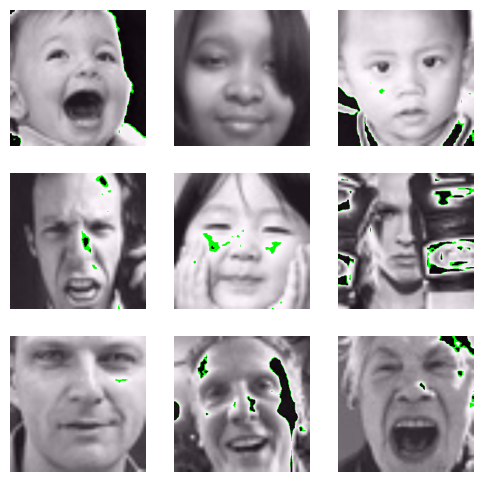

In [639]:
# Display preprocessed images

plt.figure(figsize=(6, 6))
for images, labels in train_generator.take(1): 
    preprocessed_images = preprocess_input(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = preprocessed_images[i].numpy().astype("uint8")  
        plt.imshow(img)
        plt.axis("off")
plt.show()


#### Model Design

In [640]:
# Define the model
pt_model = Sequential([
    pt_resnet50_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax') 
])


#### Compiling

In [641]:
# Compile the model
pt_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Training

In [642]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.7, patience=3, min_lr=0.0001)


In [643]:
# Train the model
history2 = pt_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


91/91 ━━━━━━━━━━━━━━━━━━━━ 959s 10s/step - accuracy: 0.1769 - loss: 8.6229 - val_accuracy: 0.3402 - val_loss: 3.5608 - learning_rate: 0.0010
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 898s 10s/step - accuracy: 0.2760 - loss: 4.9106 - val_accuracy: 0.4159 - val_loss: 2.5169 - learning_rate: 0.0010
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 897s 10s/step - accuracy: 0.3137 - loss: 4.0315 - val_accuracy: 0.4032 - val_loss: 2.1764 - learning_rate: 0.0010
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 904s 10s/step - accuracy: 0.3451 - loss: 3.6485 - val_accuracy: 0.3473 - val_loss: 2.0896 - learning_rate: 0.0010
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 896s 10s/step - accuracy: 0.3564 - loss: 3.4487 - val_accuracy: 0.4580 - val_loss: 1.8166 - learning_rate: 0.0010
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 902s 10s/step - accuracy: 0.3792 - loss: 3.3313 - val_accuracy: 0.4637 - val_loss: 1.7608 - learning_rate: 0.0010
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 904s 10s/step - accuracy: 0.3862 - loss: 3.2718 - val_a

KeyboardInterrupt: 

#### Model Evaluation

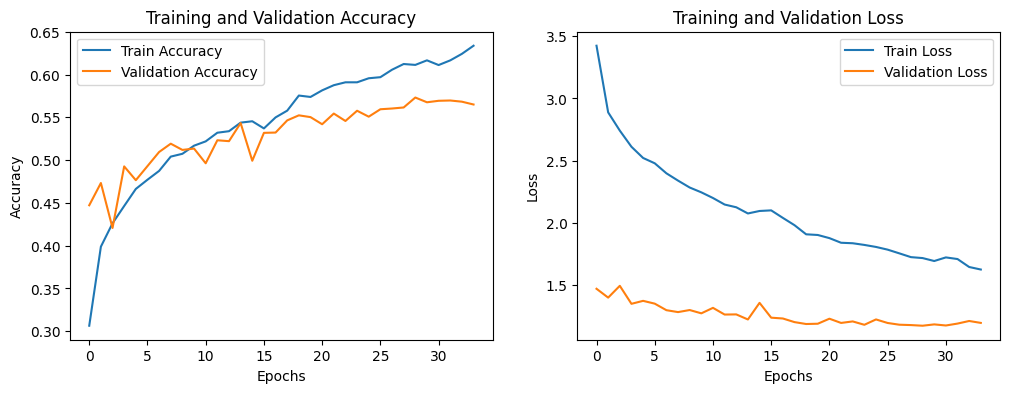

In [ ]:
# Plot training history: Model 2 - Pre-trained Resnet50 emotion classifier
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# Evaluate the model
test_loss2, test_accuracy2 = pt_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy2 * 100:.2f}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 226s 8s/step - accuracy: 0.5765 - loss: 1.1576
Test Accuracy: 58.08%


#### Save Model

In [ ]:
# Save the my model with data augmentation
model.save('my_model_pt_6356.keras')

## 5) Preparing the Dataset - Gender Classifier

In [460]:
traindir = "/Users/keikietpham/Desktop/Kunskapskontroll2_DeepLearning/images_gender/Training"
testdir = "/Users/keikietpham/Desktop/Kunskapskontroll2_DeepLearning/images_gender/Validation"
os.listdir(traindir)

['.DS_Store', 'male', 'female']

### Exploring and Displaying Images

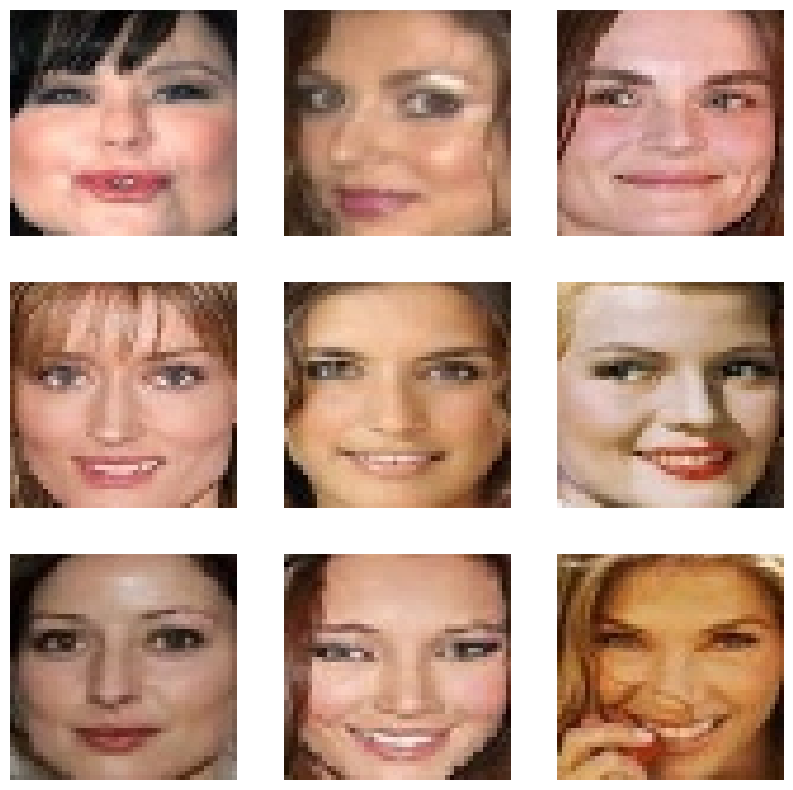

In [461]:
gender = 'female'

plt.figure(figsize=(10,10))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img_gender = load_img(traindir+'/'+gender+'/'+
                   os.listdir(traindir+'/' + gender)[i], target_size=(picture_size, picture_size))
    plt.imshow(img_gender)
    plt.axis("off")
plt.show()

### Making Training and Validation Data

In [462]:
gender_pic_size = 96

# Load Train & Validation datasets
train_gender, val_gender = image_dataset_from_directory(
    directory=traindir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb', # training dataset consists of rgb images
    batch_size=batch_size,
    image_size=(gender_pic_size, gender_pic_size),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

# Load Test dataset
test_gender = image_dataset_from_directory(
    directory=testdir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb', # test dataset consists of gray images
    batch_size=batch_size,
    image_size=(gender_pic_size, gender_pic_size),
    shuffle=False
)

Found 47009 files belonging to 2 classes.
Using 37608 files for training.
Using 9401 files for validation.
Found 11649 files belonging to 2 classes.


#### Data Augmentation

In [463]:
# Define the data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.02),
    tf.keras.layers.RandomZoom(height_factor=0.02, width_factor=0.02),
    tf.keras.layers.RandomContrast(factor=0.02),
    tf.keras.layers.RandomBrightness(factor=0.02),
    tf.keras.layers.Resizing(gender_pic_size, gender_pic_size),
])

def resize_augment(image, label):
    image = data_augmentation(image)
    return image, label

In [464]:

# Apply resizing and data augmentation to training dataset to improve learning
train_gender_aug = train_gender.map(resize_augment)

2024-05-30 21:15:27.301370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


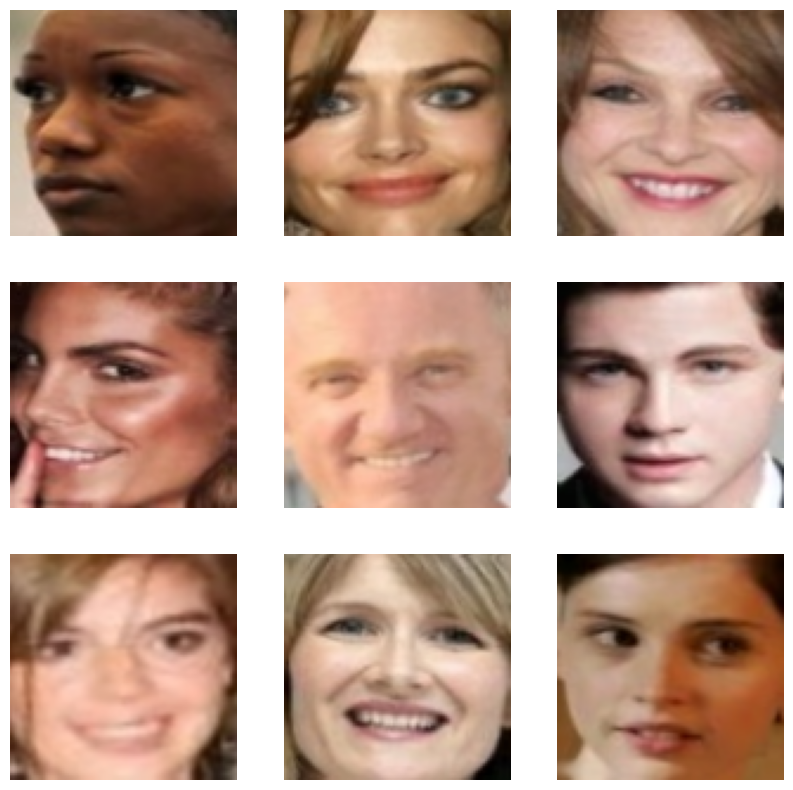

In [465]:
# Display random images after data_augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_gender.take(1):  # Take one batch from the dataset
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = np.array(augmented_images[i]).astype("float32")
        plt.imshow(img.astype("uint8"))  # Ensure proper visualization
        plt.axis("off")

plt.show()

### Model Design


### Import MobileNetV2 Pretrained model

In [466]:
# importing preprocess function for mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # when using pretrained model, use model specific preprocess function 

# Apply the preprocessing function to the datasets
def mobilenet_v2_preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_gender = train_gender_aug.map(mobilenet_v2_preprocess) # augment Training data
val_gender = val_gender.map(mobilenet_v2_preprocess)
test_gender = test_gender.map(mobilenet_v2_preprocess)

In [467]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(weights = "imagenet", include_top = False, input_shape=(gender_pic_size,gender_pic_size,3))

In [468]:
for layer in mobilenet.layers:
    layer.trainable = False

In [469]:
# checking if the layers are trainable
for layer in mobilenet.layers:
    print(f'Layer name: {layer}, is trainable: {layer.trainable}')

Layer name: <InputLayer name=input_layer_86, built=True>, is trainable: False
Layer name: <Conv2D name=Conv1, built=True>, is trainable: False
Layer name: <BatchNormalization name=bn_Conv1, built=True>, is trainable: False
Layer name: <ReLU name=Conv1_relu, built=True>, is trainable: False
Layer name: <DepthwiseConv2D name=expanded_conv_depthwise, built=True>, is trainable: False
Layer name: <BatchNormalization name=expanded_conv_depthwise_BN, built=True>, is trainable: False
Layer name: <ReLU name=expanded_conv_depthwise_relu, built=True>, is trainable: False
Layer name: <Conv2D name=expanded_conv_project, built=True>, is trainable: False
Layer name: <BatchNormalization name=expanded_conv_project_BN, built=True>, is trainable: False
Layer name: <Conv2D name=block_1_expand, built=True>, is trainable: False
Layer name: <BatchNormalization name=block_1_expand_BN, built=True>, is trainable: False
Layer name: <ReLU name=block_1_expand_relu, built=True>, is trainable: False
Layer name: <Zer

#### Model Design

In [470]:
# Create the model
model_gender = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)), # adding l2 and dropout regularizers to counter overfits of the augmented training data
    Dropout(0.5), 
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)), # adding l2 and dropout regularizers to counter overfits of the augmented training data
    Dropout(0.5),  
    Dense(2, activation='softmax')  
])

#### Compiling

In [471]:
model_gender.compile(optimizer=Adam(learning_rate=0.001),loss = "categorical_crossentropy",metrics =["accuracy"])

In [472]:
# Dummy call to build the model
model_gender.evaluate(train_gender.take(1))

# Check model summary
model_gender.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4688 - loss: 13.3328


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_30     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,177,538 (12.12 MB)

 Trainable params: 919,554 (3.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Training

In [473]:
checkpoint = ModelCheckpoint("Gender.keras", monitor = "val_accuracy", mode='max', save_best_only = True)
earlystop = EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001)

In [474]:
history3 = model_gender.fit(
    train_gender,
    steps_per_epoch=len(train_gender) // batch_size,
    epochs=50,  
    validation_data=val_gender,
    validation_steps=len(val_gender) // batch_size,
    callbacks=[checkpoint, earlystop, reduce_lr],
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6488 - loss: 10.9642 - val_accuracy: 0.8542 - val_loss: 5.7966 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7898 - loss: 5.1941 - val_accuracy: 0.8750 - val_loss: 3.5180 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8327 - loss: 3.2860 - val_accuracy: 0.8576 - val_loss: 2.5471 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8202 - loss: 2.4681 - val_accuracy: 0.8472 - val_loss: 2.0175 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8450 - loss: 1.9257 - val_accuracy: 0.8715 - val_loss: 1.6106 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8310 - loss: 1.6827 - val_accuracy: 0.8958 - val_loss: 1.4947 - learning_rate: 2.0000e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8564 - loss: 1.5230 - va

#### Model Evaluation

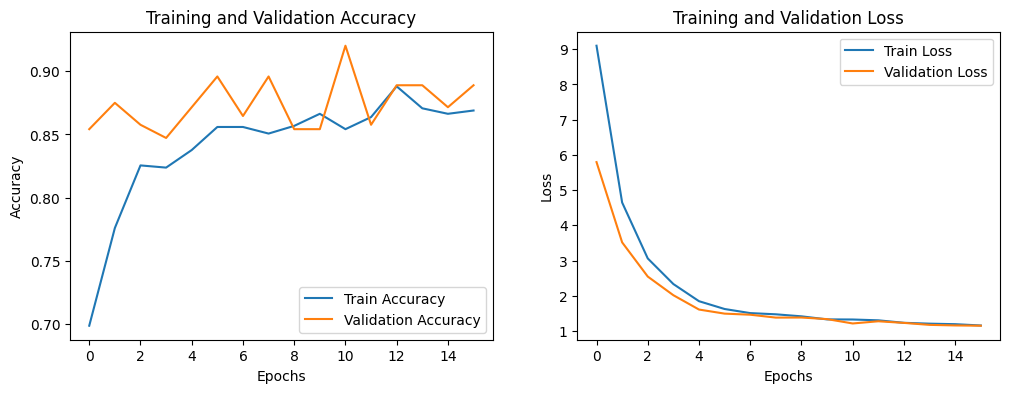

In [475]:
# Plot training history: Model 3 - Gender classifier with Pre-trained Mobilenet_v2 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [263]:
# Evaluate the model
test_loss, test_accuracy = model_gender.evaluate(test_gender)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

365/365 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.1872 - loss: 1.5478
Test Accuracy: 50.08%


#### Save Model

In [ ]:
# Save the my model with data augmentation
model_gender.save('my_model_pt_8284.keras')